In [164]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


# Kalman filter for altitude estimation  from GPS, sonar, baro. Input with accelerometer. Estimation of acceleometer bias and baro bias.

---

# I) TRAJECTORY

We assume sinusoidal trajectory

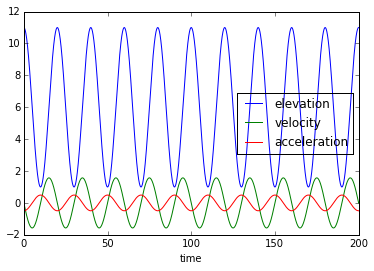

In [165]:
m = 50000       # timesteps
dt = 1/ 250.0   # update loop at 250Hz

t = np.arange(m) * dt

freq = 0.05      # Hz
amplitude = 5.0 # meter

alt_true = 405 + amplitude * np.cos(2 * np.pi * freq * t)
height_true = 6 + amplitude * np.cos(2 * np.pi * freq * t)
vel_true = - amplitude * (2 * np.pi * freq) * np.sin(2 * np.pi * freq * t)
acc_true = - amplitude * (2 * np.pi * freq)**2 * np.cos(2 * np.pi * freq * t)

plt.plot(t, height_true)
plt.plot(t, vel_true)
plt.plot(t, acc_true)
plt.legend(['elevation', 'velocity', 'acceleration'], loc='best')
plt.xlabel('time')

---

# II) MEASUREMENTS

#### Sonar

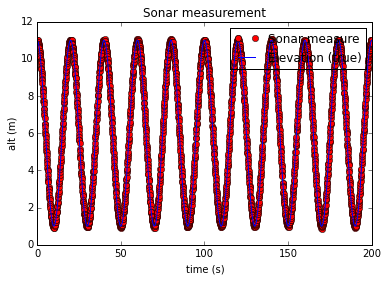

In [166]:
sonar_sampling_period = 1 / 10.0  # sonar reading at 10Hz

# Sonar noise
sigma_sonar_true = 0.05  # in meters


meas_sonar = height_true[::(sonar_sampling_period/dt)] + sigma_sonar_true * np.random.randn(m // (sonar_sampling_period/dt))
t_meas_sonar = t[::(sonar_sampling_period/dt)]

plt.plot(t_meas_sonar, meas_sonar, 'or')
plt.plot(t, height_true)
plt.legend(['Sonar measure', 'Elevation (true)'])
plt.title("Sonar measurement")
plt.xlabel('time (s)')
plt.ylabel('alt (m)')

#### Baro

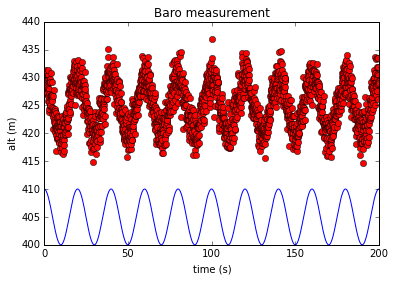

In [167]:
baro_sampling_period = 1 / 10.0  # baro reading at 10Hz

# Baro noise
sigma_baro_true = 2.0  # in meters

# Baro bias
baro_bias = 20

meas_baro = baro_bias + alt_true[::(baro_sampling_period/dt)] + sigma_baro_true * np.random.randn(m // (baro_sampling_period/dt))
t_meas_baro = t[::(baro_sampling_period/dt)]

plt.plot(t_meas_baro, meas_baro, 'or')
plt.plot(t, alt_true)
plt.title("Baro measurement")
plt.xlabel('time (s)')
plt.ylabel('alt (m)')

#### GPS

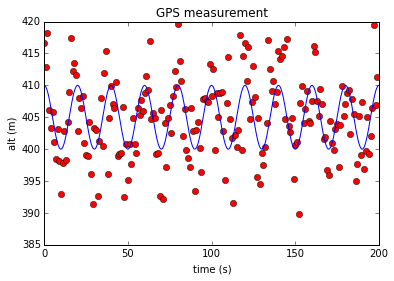

In [168]:
gps_sampling_period = 1 / 1.0  # gps reading at 1Hz

# GPS noise
sigma_gps_true = 5.0  # in meters

meas_gps = alt_true[::(gps_sampling_period/dt)] + sigma_gps_true * np.random.randn(m // (gps_sampling_period/dt))
t_meas_gps = t[::(gps_sampling_period/dt)]

plt.plot(t_meas_gps, meas_gps, 'or')
plt.plot(t, alt_true)
plt.title("GPS measurement")
plt.xlabel('time (s)')
plt.ylabel('alt (m)')

#### GPS velocity

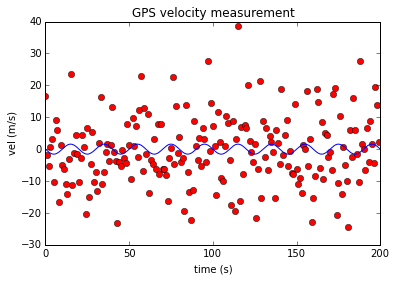

In [169]:
gpsvel_sampling_period = 1 / 1.0  # gps reading at 1Hz

# GPS noise
sigma_gpsvel_true = 10.0  # in meters/s

meas_gpsvel = vel_true[::(gps_sampling_period/dt)] + sigma_gpsvel_true * np.random.randn(m // (gps_sampling_period/dt))
t_meas_gps = t[::(gps_sampling_period/dt)]

plt.plot(t_meas_gps, meas_gpsvel, 'or')
plt.plot(t, vel_true)
plt.title("GPS velocity measurement")
plt.xlabel('time (s)')
plt.ylabel('vel (m/s)')

#### Acceleration

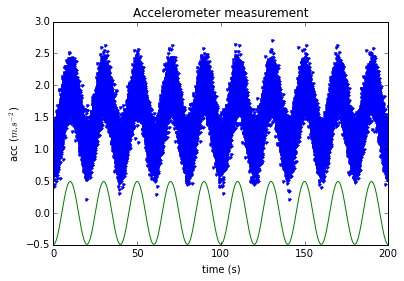

In [170]:
sigma_acc_true = 0.2    # in m.s^-2

acc_bias = 1.5
meas_acc = acc_true + sigma_acc_true * np.random.randn(m) + acc_bias
plt.plot(t, meas_acc, '.')
plt.plot(t, acc_true)
plt.title("Accelerometer measurement")
plt.xlabel('time (s)')
plt.ylabel('acc ($m.s^{-2}$)')

---

# III) PROBLEM FORMULATION

### State vector

$$x_{k} = \left[ \matrix{ z \\ h \\ \dot z \\ \zeta \\ \eta} \right] 
= \matrix{ \text{Altitude} \\ \text{Height above ground} \\ \text{Vertical speed} \\ \text{Accelerometer bias} \\ \text{baro bias}}$$

### Input vector

$$ u_{k} = \left[ \matrix{ \ddot z } \right] = \text{Accelerometer} $$

### Formal definition (Law of motion):


$$ x_{k+1} = \textbf{A} \cdot x_{k} + \textbf{B} \cdot u_{k} $$

$$ x_{k+1} = \left[ 
\matrix{   1 & 0 & \Delta_t & \frac{1}{2} \Delta t^2 & 0
        \\ 0 & 1 & \Delta t & \frac{1}{2} \Delta t^2 & 0
        \\ 0 & 0 & 1        & \Delta t               & 0
        \\ 0 & 0 & 0        & 1                      & 0
        \\ 0 & 0 & 0        & 0                      & 0} \right] 
\cdot 
\left[ \matrix{ z \\ h \\ \dot z \\ \zeta \\ \eta } \right] 
+ \left[ \matrix{ \frac{1}{2} \Delta t^2 \\ \frac{1}{2} \Delta t^2 \\ \Delta t \\ 0 \\ 0} \right] 
\cdot
\left[ \matrix{ \ddot z } \right] $$

### Measurement

$$ y = H \cdot x $$

$$ \left[ \matrix{ y_{sonar} \\ y_{baro} \\ y_{gps} \\ y_{gpsvel} } \right]
    = \left[ \matrix{ 0 & 1 & 0 & 0 & 0 
                    \\ 1 & 0 & 0 & 0 & 1 
                    \\ 1 & 0 & 0 & 0 & 0
                    \\ 0 & 0 & 1 & 0 & 0 } \right] \cdot \left[ \matrix{ z \\ h \\ \dot z \\ \zeta \\ \eta } \right]  $$

Measures are done separately according to the refresh rate of each sensor

We measure the height from sonar

$$ y_{sonar} = H_{sonar} \cdot x $$

$$ y_{sonar} = \left[ \matrix{ 0 & 1 & 0 & 0 & 0 } \right] \cdot x $$

We measure the altitude from barometer

$$ y_{baro} = H_{baro} \cdot x $$

$$ y_{baro} = \left[ \matrix{ 1 & 0 & 0 & 0 & 1 } \right] \cdot x $$

We measure the altitude from gps

$$ y_{gps} = H_{gps} \cdot x $$

$$ y_{gps} = \left[ \matrix{ 1 & 0 & 0 & 0 & 0 } \right] \cdot x $$

We measure the velocity from gps

$$ y_{gpsvel} = H_{gpsvel} \cdot x $$

$$ y_{gpsvel} = \left[ \matrix{ 0 & 0 & 1 & 0 & 0 } \right] \cdot x $$

# IV) IMPLEMENTATION

## Initial state $x_0$

In [171]:
x = np.matrix([0.0, 0.0, 0.0, 0.0, 0.0]).T
print(x, x.shape)

[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]] (5, 1)


## Initial uncertainty $P_0$

In [172]:
P = np.diag([100.0, 100.0, 100.0, 100.0, 100.0])
print(P, P.shape)

[[ 100.    0.    0.    0.    0.]
 [   0.  100.    0.    0.    0.]
 [   0.    0.  100.    0.    0.]
 [   0.    0.    0.  100.    0.]
 [   0.    0.    0.    0.  100.]] (5, 5)


## Dynamic matrix $A$

In [173]:
dt = 1 / 250.0  # Time step between filter steps (update loop at 250Hz)

A = np.matrix([[1.0, 0.0, dt,  0.5*dt**2, 0.0],
               [0.0, 1.0, dt,  0.5*dt**2, 0.0],
               [0.0, 0.0, 1.0, dt,        0.0],
               [0.0, 0.0, 0.0, 1.0,       0.0],
               [0.0, 0.0, 0.0, 0.0,       1.0]])
print(A, A.shape)

[[  1.00000000e+00   0.00000000e+00   4.00000000e-03   8.00000000e-06
    0.00000000e+00]
 [  0.00000000e+00   1.00000000e+00   4.00000000e-03   8.00000000e-06
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00   4.00000000e-03
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00]] (5, 5)


## Disturbance Control Matrix $B$

In [174]:
B = np.matrix([[0.5*dt**2],
               [0.5*dt**2],
               [dt ],
               [0.0],
               [0.0]])
print(B, B.shape)

[[  8.00000000e-06]
 [  8.00000000e-06]
 [  4.00000000e-03]
 [  0.00000000e+00]
 [  0.00000000e+00]] (5, 1)


## Measurement Matrix $H$

In [175]:
H_sonar = np.matrix([[0.0, 1.0, 0.0, 0.0, 0.0]])
print(H_sonar, H_sonar.shape)

H_baro = np.matrix([[1.0, 0.0, 0.0, 0.0, 1.0]])
print(H_baro, H_baro.shape)

H_gps = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0]])
print(H_gps, H_gps.shape)

H_gpsvel = np.matrix([[0.0, 0.0, 1.0, 0.0, 0.0]])
print(H_gpsvel, H_gpsvel.shape)

[[ 0.  1.  0.  0.  0.]] (1, 5)
[[ 1.  0.  0.  0.  1.]] (1, 5)
[[ 1.  0.  0.  0.  0.]] (1, 5)
[[ 0.  0.  1.  0.  0.]] (1, 5)


## Measurement noise covariance $R$

In [176]:
# sonar
sigma_sonar = sigma_sonar_true # sonar noise

R_sonar = np.matrix([[sigma_sonar**2]])
print(R_sonar, R_sonar.shape)

# baro
sigma_baro = sigma_baro_true # sonar noise

R_baro = np.matrix([[sigma_baro**2]])
print(R_baro, R_baro.shape)

# gps
sigma_gps = sigma_gps_true # sonar noise

R_gps = np.matrix([[sigma_gps**2]])
print(R_gps, R_gps.shape)

# gpsvel
sigma_gpsvel = sigma_gpsvel_true # sonar noise

R_gpsvel = np.matrix([[sigma_gpsvel**2]])
print(R_gpsvel, R_gpsvel.shape)

[[ 0.0025]] (1, 1)
[[ 4.]] (1, 1)
[[ 25.]] (1, 1)
[[ 100.]] (1, 1)


## Process noise covariance $Q$

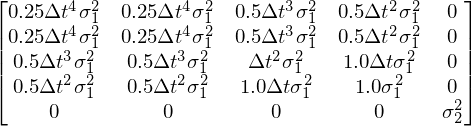

In [204]:
from sympy import Symbol, Matrix, latex
from sympy.interactive import printing
import sympy
printing.init_printing()
dts = Symbol('\Delta t')
s1 = Symbol('\sigma_1')  # drift of accelerometer bias
s2 = Symbol('\sigma_2')  # drift of barometer bias
Q = sympy.zeros(5)
Qs = Matrix([[0.5*dts**2], [0.5*dts**2], [dts], [1.0]])
Q[:4, :4] = Qs*Qs.T*s1**2
Q[4, 4] = s2**2
Q


In [206]:
sigma_acc_drift = 0.0001
sigma_baro_drift = 0.0001

G = np.matrix([[0.5*dt**2],
               [0.5*dt**2],
               [dt],
               [1.0]])
Q = np.zeros([5, 5])
Q[:4, :4] = G*G.T*sigma_acc_drift**2
Q[4, 4] = sigma_baro_drift**2
print(Q, Q.shape)

[[  6.40000000e-19   6.40000000e-19   3.20000000e-16   8.00000000e-14
    0.00000000e+00]
 [  6.40000000e-19   6.40000000e-19   3.20000000e-16   8.00000000e-14
    0.00000000e+00]
 [  3.20000000e-16   3.20000000e-16   1.60000000e-13   4.00000000e-11
    0.00000000e+00]
 [  8.00000000e-14   8.00000000e-14   4.00000000e-11   1.00000000e-08
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e-08]] (5, 5)


## Identity Matrix

In [179]:
I = np.eye(5)
print(I, I.shape)

[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]] (5, 5)


## Input

In [180]:
u = meas_acc
print(u, u.shape)

[ 1.16591732  1.16850312  1.25487572 ...,  1.25088366  1.259522    1.09342471] (50000,)


---

# V) TEST

## Filter loop

In [190]:
# Re init state
# State
x[0] = 0.0
x[1] = 0.0
x[2] = 0.0
x[3] = 0.0
x[4] = 0.0

# Estimate covariance
P[0,0] = 1000.0
P[1,1] = 100.0
P[2,2] = 100.0
P[3,3] = 100.0
P[4,4] = 100.0

# Preallocation for Plotting
# estimate
zt = []
ht = []
dzt= []
zetat=[]
etat = []

# covariance
Pz = []
Ph = []
Pdz= []
Pzeta=[]
Peta=[]

# sonar off/on
sonar_off = 10000
sonar_on = 40000

for filterstep in range(m):    
    
    # ========================
    # Time Update (Prediction)
    # ========================
    
    # Project the state ahead
    x = A*x + B*u[filterstep]
    
    # Project the error covariance ahead
    P = A*P*A.T + Q    
    

    # ===============================
    # Measurement Update (Correction)
    # ===============================
    
    # Sonar (only at the beginning, ex take off)
    if filterstep%25 == 0 and (filterstep <sonar_off or filterstep>sonar_on):    
        # Compute the Kalman Gain
        S_sonar = H_sonar*P*H_sonar.T + R_sonar
        K_sonar = (P*H_sonar.T) * np.linalg.pinv(S_sonar)
    
        # Update the estimate via z
        Z_sonar = meas_sonar[filterstep//25]
        y_sonar = Z_sonar - (H_sonar*x)                            # Innovation or Residual
        x = x + (K_sonar*y_sonar)
    
        # Update the error covariance
        P = (I - (K_sonar*H_sonar))*P
        
    # Baro
    if filterstep%25 == 0:    
        # Compute the Kalman Gain
        S_baro = H_baro*P*H_baro.T + R_baro
        K_baro = (P*H_baro.T) * np.linalg.pinv(S_baro)
    
        # Update the estimate via z
        Z_baro = meas_baro[filterstep//25]
        y_baro = Z_baro - (H_baro*x)                            # Innovation or Residual
        x = x + (K_baro*y_baro)
    
        # Update the error covariance
        P = (I - (K_baro*H_baro))*P

    # GPS
    if filterstep%250 == 0:    
        # Compute the Kalman Gain
        S_gps = H_gps*P*H_gps.T + R_gps
        K_gps = (P*H_gps.T) * np.linalg.pinv(S_gps)
    
        # Update the estimate via z
        Z_gps = meas_gps[filterstep//250]
        y_gps = Z_gps - (H_gps*x)                            # Innovation or Residual
        x = x + (K_gps*y_gps)
    
        # Update the error covariance
        P = (I - (K_gps*H_gps))*P

    # GPSvel
    if filterstep%250 == 0:    
        # Compute the Kalman Gain
        S_gpsvel = H_gpsvel*P*H_gpsvel.T + R_gpsvel
        K_gpsvel = (P*H_gpsvel.T) * np.linalg.pinv(S_gpsvel)
    
        # Update the estimate via z
        Z_gpsvel = meas_gpsvel[filterstep//250]
        y_gpsvel = Z_gpsvel - (H_gpsvel*x)                            # Innovation or Residual
        x = x + (K_gpsvel*y_gpsvel)
    
        # Update the error covariance
        P = (I - (K_gpsvel*H_gpsvel))*P
        
        
    # ========================
    # Save states for Plotting
    # ========================
    zt.append(float(x[0]))
    ht.append(float(x[1]))
    dzt.append(float(x[2]))
    zetat.append(float(x[3]))
    etat.append(float(x[4]))
    
    Pz.append(float(P[0,0]))
    Ph.append(float(P[1,1]))
    Pdz.append(float(P[2,2]))
    Pzeta.append(float(P[3,3]))
    Peta.append(float(P[4,4]))

# VI) PLOT

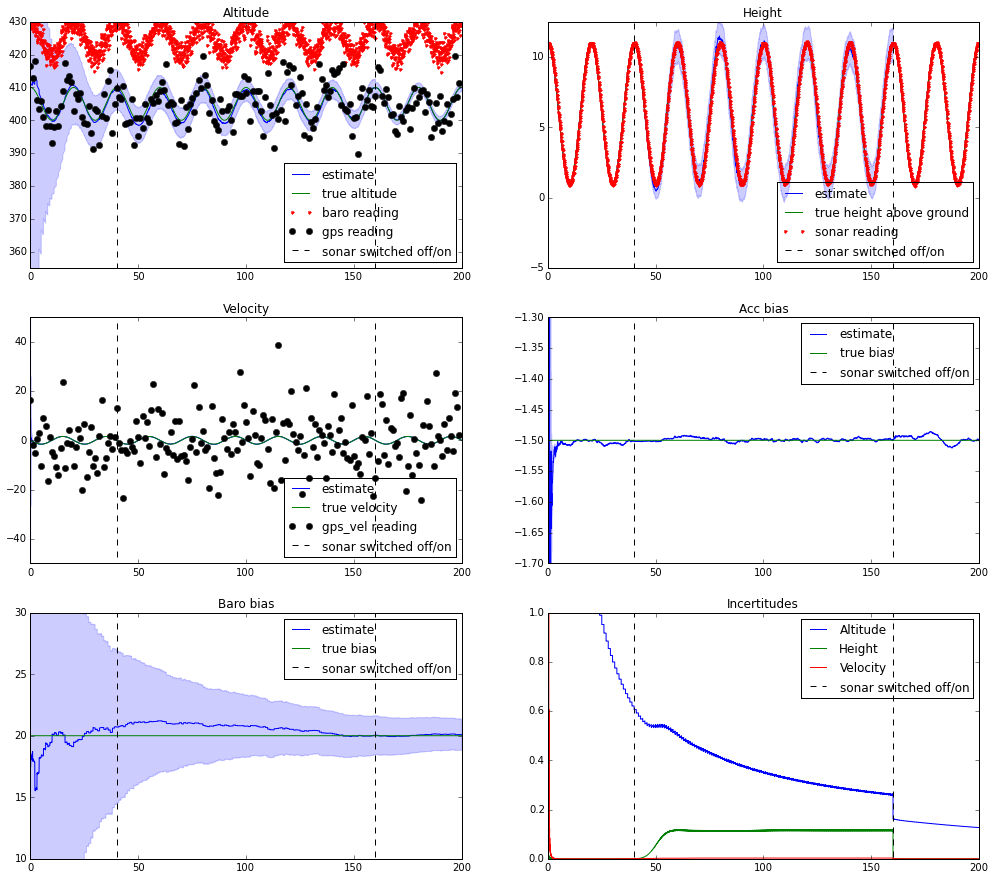

In [194]:
plt.figure(figsize=(17,15))

plt.subplot(321)
plt.plot(t, zt, color='b')
plt.fill_between(t, np.array(zt) - 10* np.array(Pz), np.array(zt) + 10*np.array(Pz), alpha=0.2, color='b')
plt.plot(t, alt_true, 'g')
plt.plot(t_meas_baro, meas_baro, '.r')
plt.plot(t_meas_gps, meas_gps, 'ok')
plt.plot([t[sonar_off], t[sonar_off]], [-1000, 1000], '--k')
plt.plot([t[sonar_on], t[sonar_on]], [-1000, 1000], '--k')
#plt.ylim([1.7, 2.3])
plt.ylim([405 - 10 * amplitude, 405 + 5 * amplitude])
plt.legend(['estimate', 'true altitude', 'baro reading', 'gps reading', 'sonar switched off/on'], loc='lower right')
plt.title('Altitude')

plt.subplot(322)
plt.plot(t, ht, color='b')
plt.fill_between(t, np.array(ht) - 10* np.array(Ph), np.array(ht) + 10*np.array(Ph), alpha=0.2, color='b')
plt.plot(t, height_true, 'g')
plt.plot(t_meas_sonar, meas_sonar, '.r')
plt.plot([t[sonar_off], t[sonar_off]], [-1000, 1000], '--k')
plt.plot([t[sonar_on], t[sonar_on]], [-1000, 1000], '--k')
#plt.ylim([1.7, 2.3])
plt.ylim([5 - 2 * amplitude, 5 + 1.5 * amplitude])
#plt.ylim([5 - 1 * amplitude, 5 + 1 * amplitude])
plt.legend(['estimate', 'true height above ground', 'sonar reading', 'sonar switched off/on'], loc='lower right')
plt.title('Height')

plt.subplot(323)
plt.plot(t, dzt, color='b')
plt.fill_between(t, np.array(dzt) - 10* np.array(Pdz), np.array(dzt) + 10*np.array(Pdz), alpha=0.2, color='b')
plt.plot(t, vel_true, 'g')
plt.plot(t_meas_gps, meas_gpsvel, 'ok')
plt.plot([t[sonar_off], t[sonar_off]], [-1000, 1000], '--k')
plt.plot([t[sonar_on], t[sonar_on]], [-1000, 1000], '--k')
#plt.ylim([1.7, 2.3])
plt.ylim([0 - 10.0 * amplitude,  + 10.0 * amplitude])
plt.legend(['estimate', 'true velocity', 'gps_vel reading', 'sonar switched off/on'], loc='lower right')
plt.title('Velocity')

plt.subplot(324)
plt.plot(t, zetat, color='b')
plt.fill_between(t, np.array(zetat) - 10* np.array(Pzeta), np.array(zetat) + 10*np.array(Pzeta), alpha=0.2, color='b')
plt.plot(t, -acc_bias * np.ones_like(t), 'g')
plt.plot([t[sonar_off], t[sonar_off]], [-1000, 1000], '--k')
plt.plot([t[sonar_on], t[sonar_on]], [-1000, 1000], '--k')
plt.ylim([-acc_bias-0.2, -acc_bias+0.2])
# plt.ylim([0 - 2.0 * amplitude,  + 2.0 * amplitude])
plt.legend(['estimate', 'true bias', 'sonar switched off/on'])
plt.title('Acc bias')

plt.subplot(325)
plt.plot(t, etat, color='b')
plt.fill_between(t, np.array(etat) - 10* np.array(Peta), np.array(etat) + 10*np.array(Peta), alpha=0.2, color='b')
plt.plot(t, baro_bias * np.ones_like(t), 'g')
plt.plot([t[sonar_off], t[sonar_off]], [-1000, 1000], '--k')
plt.plot([t[sonar_on], t[sonar_on]], [-1000, 1000], '--k')
plt.ylim([baro_bias-10.0, baro_bias+10.0])
# plt.ylim([0 - 2.0 * amplitude,  + 2.0 * amplitude])
plt.legend(['estimate', 'true bias', 'sonar switched off/on'])
plt.title('Baro bias')

plt.subplot(326)
plt.plot(t, Pz)
plt.plot(t, Ph)
plt.plot(t, Pdz)
plt.ylim([0, 1.0])
plt.plot([t[sonar_off], t[sonar_off]], [-1000, 1000], '--k')
plt.plot([t[sonar_on], t[sonar_on]], [-1000, 1000], '--k')
plt.legend(['Altitude', 'Height', 'Velocity', 'sonar switched off/on'])
plt.title('Incertitudes')